In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy import stats
from scipy import interpolate
import matplotlib.cm as cm
import numpy.polynomial.polynomial as poly  
%matplotlib inline

In [2]:
df = pd.read_csv('../WORK/surf_bT_ret_171031.txt', header=None, delimiter=r"\s+", names = [' ', 'UTC', 'MY', 'L_s', 'LTST', 'Surf_lat', 'Surf_lon', 'Surf_rad', 'Surf_elev', 'T_surf', 'T_surf_err', 'Dust_column', 'Dust_column_err', 'H2Oice_column', 'H2Oice_column_err', 'p_surf', 'p_surf_err', 'P_qual', 'T_qual'])
#read data into dataframe

The above reads the text file into a dataframe

In [3]:
########
# pco2 #
########
# --------------------------------------------
# Equilibrium vapor pressure over solid CO2
# Brown and Ziegler (1980)
# --------------------------------------------
# Input:
#    T = temperature of solid [K]
# Output:
#    vapor pressure [Pa]
def pco2(T):
    A0 = 2.13807649e1
    A1 = -2.57064700e3
    A2 = -7.78129489e4
    A3 = 4.32506256e6
    A4 = -1.20671368e8
    A5 = 1.34966306e9
    # Pressure in torr
    ptorr = np.exp(A0 + (A1/(T)) + (A2/(T**2)) + (A3/(T**3)) + (A4/(T**4)) + (A5/(T**5)))
    # Pressure in Pa
    p = ptorr*133.3223684211
    return p

In [4]:
########
# tco2 #
########
#-------------------------------------------------------------------------
#Calculate (approximately) the condensation temperature of CO2 at the
#specified pressure(s) (Pa), using the empirical law from Brown and 
#Ziegler (1980). This function calls the pco2() routine.
#-------------------------------------------------------------------------
# Input:
#    p = vapor pressure [Pa]
# Output:
#    temperature of solid [K]
def tco2(p):
    Trange = np.arange(30,350)
    T = interpolate.pchip_interpolate(pco2(Trange),Trange,p)
    return T

Both Formulas above are to calculate the equilibrium vapor pressure and temperature for carbon dioxide

In [5]:
# Function: ls2sol
# Purpose: convert Mars "Lsubs" to sol (day of year)
# Input: 
#    ls = areocentric longitude of the Sun [array]
#    n = degree of polynomial fit [scalar]
def ls2sol(ls, n):
    # data
    lsdata = (0,30,60,90,120,150,180,210,240,270,300,330,360) # L_s array
    soldata = (0,61.2,126.6,193.3,257.8,317.5,371.9,421.6,468.5,514.6,562.0,612.9,668.6) # Sol array
    
    # polynomial fit
    p = np.polyfit(lsdata, soldata, n)
    
    # sol for Ls input
    sol = np.polyval(p, ls)
    
    # return result
    return sol

Formula to convert solar longitude to Sols

In [6]:
df['Sol'] = ls2sol(df['L_s'],8)
dfday = df[df['LTST'] >= .5]
dfnight = df[df['LTST'] <= .5]

In [7]:
cond = (df['MY'],df['L_s'],pco2(df['T_surf']), df['p_surf'], tco2(df['p_surf']), df['T_surf'], df['LTST'], df['Surf_lat'], df['Surf_lon'], df['Dust_column'] , df['Sol'] )
cond_right= np.transpose(cond)
CO2 = pd.DataFrame(list(cond_right))
CO2.columns = ['MY','L_s','Eq_Vap_P','p_surf','Eq_Vap_T','T_surf','LTST', 'Surf_lat', 'Surf_lon', 'Dust_column', 'Sol']

In [8]:
newCO2 = CO2[CO2['Eq_Vap_P'] <= CO2['p_surf']]

In [9]:
CO2day = CO2[CO2['LTST'] >= 0.5]
CO2night = CO2[CO2['LTST'] <= 0.5]

In [10]:
def MYretrieval(dataframe, MY):
    if MY == '28':
        return dataframe[(dataframe['MY'] == 28)]
    elif MY == '29':
        return dataframe[(dataframe['MY'] == 29)]
    elif MY == '30':
        return dataframe[(dataframe['MY'] == 30)]
    elif MY == '31':
        return dataframe[(dataframe['MY'] == 31)]
    elif MY == '32':
        return dataframe[(dataframe['MY'] == 32)]
    elif MY == '33':
        return dataframe[(dataframe['MY'] == 33)]
    elif MY == '34':
        return dataframe[(dataframe['MY'] == 34)]
    elif MY == '35':
        return dataframe[(dataframe['MY'] == 35)]

In [11]:
def CreateSubFrame(MarsDF, RanL_s, RanLat, RanLong):
    '''Function to divide previously created data frames in smaller data frames by providing ranges
    Input:
    MarsYearDF: Mars Data frames 
    RanL_s: range of Solar Longitude example [0,360]
    RanAlbedo: Albedo Range example [0.5,1.0]
    RanSZA Solar Zenith angle range example [0,45]
    RanLat and RanLong are set as default
    Output: Several Subframes'''
    L_s_MYDF = MarsDF['L_s']
    Lat_MYDF = MarsDF['Surf_lat']
    Long_MYDF = MarsDF['Surf_lon']
    MY_SUB = MarsDF[(L_s_MYDF <= RanL_s[-1])  & (L_s_MYDF >= RanL_s[0]) &
                        (Lat_MYDF <= RanLat[-1] ) & (Lat_MYDF >= RanLat[0]) & 
                        (Long_MYDF <= RanLong[-1]) & (Long_MYDF >= RanLong[0])]
    return MY_SUB

In [12]:
def column(MYDict, Parameter):
    '''Function to run statistics on data on the subframes from the dictionaries created by the SubDict function
    Input:
    MYDict: Dictionary Created by the SubDict Function
    Output:
    SubAvg: Average of the Albedo for each subframe in the dictionary
    SubStd: Standard Deviation of the Albedo for each subframe in the dictionary
    Sub_L_s: Average of the  Solar Longitude range for each subframe in the dictionary'''
    SubframeNum = len(MYDict.keys())
    SubTemp = []
    SubPres =[]
    SubMY = []
    SubLat =[]
    SubLong = []
    SubDust =[]
    SubSol = []
    SubStr = 'DataFrame{}'
    for i in range(SubframeNum):
        Subframe = MYDict[SubStr.format(i)]
        SubTemp.append((Subframe['T_surf'].values))
        SubPres.append((Subframe['p_surf'].values))
        SubMY.append((Subframe['MY'].values))
        SubLat.append((Subframe['Surf_lat'].values))
        SubLong.append((Subframe['Surf_lon'].values))
        SubDust.append((Subframe['Dust_column'].values))
        SubSol.append((Subframe['Sol'].values))
    SubTemp = np.array(SubTemp)
    SubPres = np.array(SubPres)
    SubMY = np.array(SubMY)
    SubLat = np.array(SubLat)
    SubLong = np.array(SubLong)
    SubDust = np.array(SubDust)
    SubSol = np.array(SubSol)
    if Parameter =='Temperature':
        return SubTemp
    elif Parameter =='Pressure': 
        return SubPres
    elif Parameter =='Martian Year':
        return SubMY 
    elif Parameter =='Latitude':
        return SubLat 
    elif Parameter =='Longitude':
        return SubLong
    elif Parameter =='Dust Column':
        return SubDust
    elif Parameter =='Sol':
        return SubSol 

In [13]:
def IRFlux(T):
    '''Calculate the luminosity of the thing.'''
    sigma = 5.67e-8 # W/m**2/K**4
    boltz = sigma * T**4
    return boltz

In [14]:
def lattolong(phi):
    r = (3376.2)*np.cos((phi*np.pi/180))
    x = (2*np.pi*r)/360 
    return x

In [15]:
def square(lat,lon,size=59.157935, type = 'km'): # 1 degree latitude (Co-created with Tyler Horvath)
    radius = 3389.5 # mars radius in km
    d2r = np.pi/180
    if type == 'km': # treat size input as km if >= 59....
        lat_deg = size*180/(np.pi*radius)
        upper_lat = lat + .5 * lat_deg
        lower_lat = lat - .5 * lat_deg
        lon_deg = size / (np.pi * np.cos(upper_lat*d2r) / 180)
        left_lon = lon - .5 * lon_deg * size
        right_lon = lon + .5 * lon_deg * size
        return(lower_lat, upper_lat, right_lon, left_lon)
    else:
        upper_lat = lat + .5 * size
        lower_lat = lat - .5 * size
        leng = radius * np.pi * np.cos(upper_lat*d2r)*2
        lon_deg = 59.157935*size/leng*360
        left_lon = lon - .5 * lon_deg 
        right_lon = lon + .5 * lon_deg
        return(lower_lat, upper_lat, right_lon, left_lon)

In [16]:
dfday28 = MYretrieval(dfday, '28')
dfday29 = MYretrieval(dfday, '29')
dfday30 = MYretrieval(dfday, '30')
dfday31 = MYretrieval(dfday, '31')
dfday32 = MYretrieval(dfday, '32')
dfday33 = MYretrieval(dfday, '33')
dfday34 = MYretrieval(dfday, '34')
dfday35 = MYretrieval(dfday, '35')

dfnight28 = MYretrieval(dfnight, '28')
dfnight29 = MYretrieval(dfnight, '29')
dfnight30 = MYretrieval(dfnight, '30')
dfnight31 = MYretrieval(dfnight, '31')
dfnight32 = MYretrieval(dfnight, '32')
dfnight33 = MYretrieval(dfnight, '33')
dfnight34 = MYretrieval(dfnight, '34')
dfnight35 = MYretrieval(dfnight, '35')

CO2day28 = MYretrieval(CO2day, '28')
CO2day29 = MYretrieval(CO2day, '29')
CO2day30 = MYretrieval(CO2day, '30')
CO2day31 = MYretrieval(CO2day, '31')
CO2day32 = MYretrieval(CO2day, '32')
CO2day33 = MYretrieval(CO2day, '33')
CO2day34 = MYretrieval(CO2day, '34')
CO2day35 = MYretrieval(CO2day, '35')

CO2night28 = MYretrieval(CO2night, '28')
CO2night29 = MYretrieval(CO2night, '29')
CO2night30 = MYretrieval(CO2night, '30')
CO2night31 = MYretrieval(CO2night, '31')
CO2night32 = MYretrieval(CO2night, '32')
CO2night33 = MYretrieval(CO2night, '33')
CO2night34 = MYretrieval(CO2night, '34')
CO2night35 = MYretrieval(CO2night, '35')

In [17]:
Lyot =square(50.8, 150.7, size=4, type = 'deg')

In [18]:
Lyot[0],Lyot[1],Lyot[2],Lyot[3]

(48.8, 52.8, 154.00797705613368, 147.39202294386629)

In [19]:
Lyot_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))

Lyot_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))

Lyot_CO2day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))

Lyot_CO2night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))
Lyot_CO2night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Lyot[0],Lyot[1]), RanLong=np.linspace(Lyot[3],Lyot[2]))

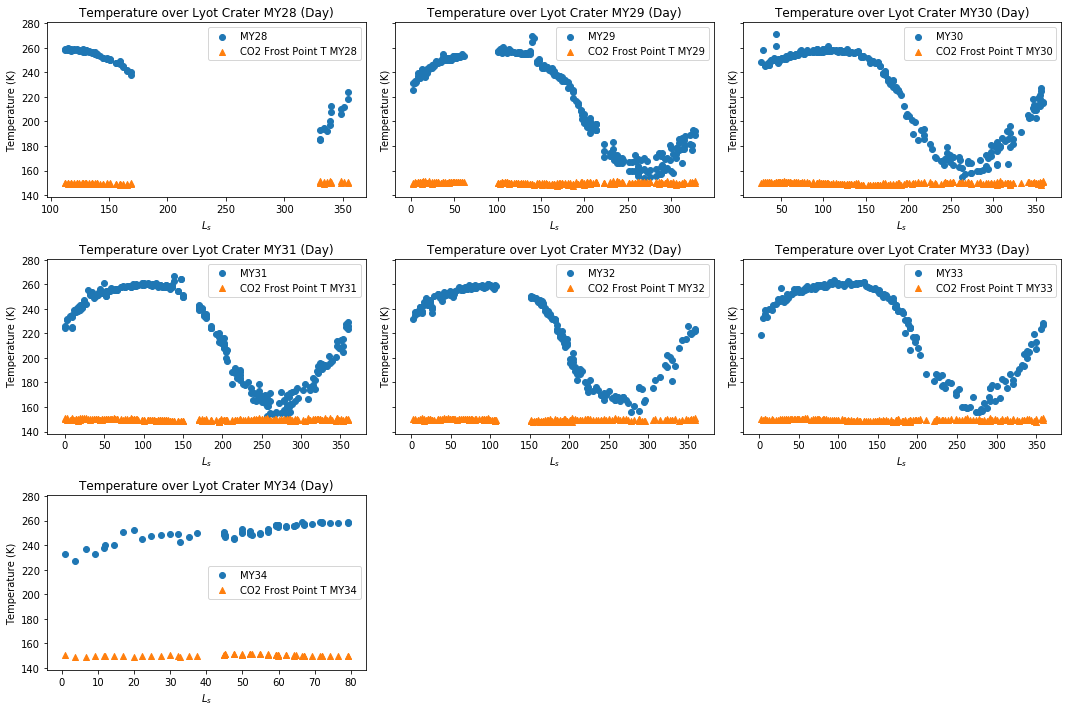

In [20]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Lyot_SubframesDayMY28['L_s'], Lyot_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(Lyot_CO2day28['L_s'],Lyot_CO2day28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY28 (Day)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Lyot_SubframesDayMY29['L_s'], Lyot_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(Lyot_CO2day29['L_s'],Lyot_CO2day29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY29 (Day)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Lyot_SubframesDayMY30['L_s'], Lyot_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(Lyot_CO2day30['L_s'],Lyot_CO2day30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY30 (Day)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Lyot_SubframesDayMY31['L_s'], Lyot_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(Lyot_CO2day31['L_s'],Lyot_CO2day31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY31 (Day)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Lyot_SubframesDayMY32['L_s'], Lyot_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(Lyot_CO2day32['L_s'],Lyot_CO2day32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY32 (Day)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Lyot_SubframesDayMY33['L_s'], Lyot_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(Lyot_CO2day33['L_s'],Lyot_CO2day33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY33 (Day)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Lyot_SubframesDayMY34['L_s'], Lyot_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(Lyot_CO2day34['L_s'],Lyot_CO2day34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY34 (Day)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

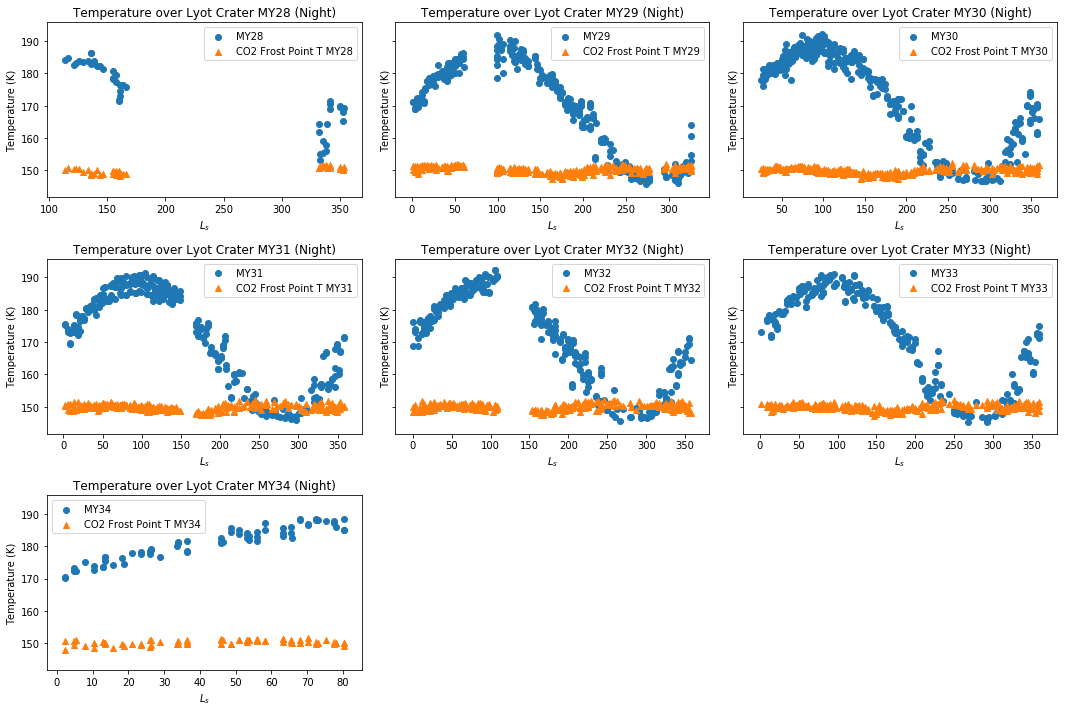

In [21]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Lyot_SubframesNightMY28['L_s'], Lyot_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(Lyot_CO2night28['L_s'],Lyot_CO2night28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY28 (Night)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Lyot_SubframesNightMY29['L_s'], Lyot_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(Lyot_CO2night29['L_s'],Lyot_CO2night29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY29 (Night)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Lyot_SubframesNightMY30['L_s'], Lyot_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(Lyot_CO2night30['L_s'],Lyot_CO2night30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY30 (Night)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Lyot_SubframesNightMY31['L_s'], Lyot_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(Lyot_CO2night31['L_s'],Lyot_CO2night31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY31 (Night)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Lyot_SubframesNightMY32['L_s'], Lyot_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(Lyot_CO2night32['L_s'],Lyot_CO2night32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY32 (Night)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Lyot_SubframesNightMY33['L_s'], Lyot_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(Lyot_CO2night33['L_s'],Lyot_CO2night33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY33 (Night)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Lyot_SubframesNightMY34['L_s'], Lyot_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(Lyot_CO2night34['L_s'],Lyot_CO2night34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater MY34 (Night)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

In [22]:
Lyot_SubframesDay = pd.concat([Lyot_SubframesDayMY28,
                              Lyot_SubframesDayMY29,
                              Lyot_SubframesDayMY30,
                              Lyot_SubframesDayMY31,
                              Lyot_SubframesDayMY32,
                              Lyot_SubframesDayMY33,
                              Lyot_SubframesDayMY34])

In [23]:
Lyot_SubframesNight = pd.concat([Lyot_SubframesNightMY28,
                              Lyot_SubframesNightMY29,
                              Lyot_SubframesNightMY30,
                              Lyot_SubframesNightMY31,
                              Lyot_SubframesNightMY32,
                              Lyot_SubframesNightMY33,
                              Lyot_SubframesNightMY34])

In [24]:
Lyot_SubframesDay = Lyot_SubframesDay.drop([' ','UTC'], axis=1)
Lyot_SubframesDay.to_csv('Lyot Crater MCS Data Day', sep=' ')

In [25]:
Lyot_SubframesNight = Lyot_SubframesNight.drop([' ','UTC'], axis=1)
Lyot_SubframesNight.to_csv('Lyot Crater MCS Data Night', sep=' ')

In [26]:
F9 = square(64.625, 135.937, size=4, type = 'deg')

In [27]:
F9_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))

F9_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))

F9_CO2day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))

F9_CO2night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))
F9_CO2night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(F9[0],F9[1]), RanLong=np.linspace(F9[3], F9[2]))

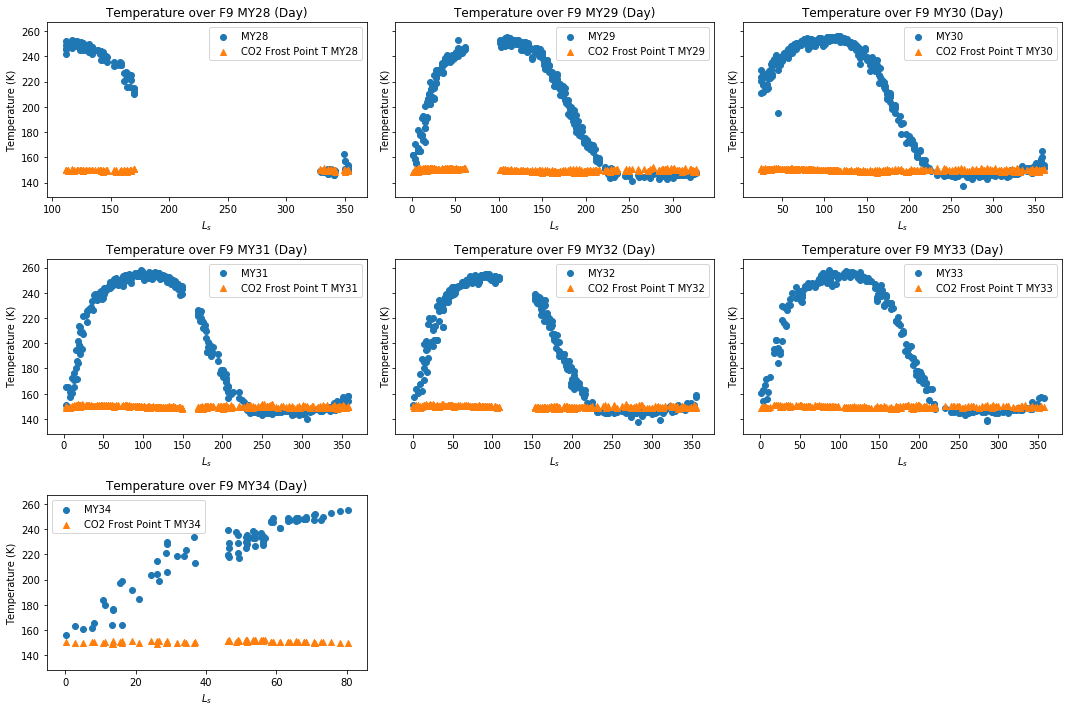

In [28]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(F9_SubframesDayMY28['L_s'],F9_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(F9_CO2day28['L_s'],F9_CO2day28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY28 (Day)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(F9_SubframesDayMY29['L_s'],F9_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(F9_CO2day29['L_s'],F9_CO2day29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY29 (Day)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(F9_SubframesDayMY30['L_s'],F9_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(F9_CO2day30['L_s'],F9_CO2day30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY30 (Day)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(F9_SubframesDayMY31['L_s'],F9_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(F9_CO2day31['L_s'],F9_CO2day31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY31 (Day)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(F9_SubframesDayMY32['L_s'],F9_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(F9_CO2day32['L_s'],F9_CO2day32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY32 (Day)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(F9_SubframesDayMY33['L_s'],F9_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(F9_CO2day33['L_s'],F9_CO2day33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY33 (Day)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(F9_SubframesDayMY34['L_s'],F9_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(F9_CO2day34['L_s'],F9_CO2day34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY34 (Day)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

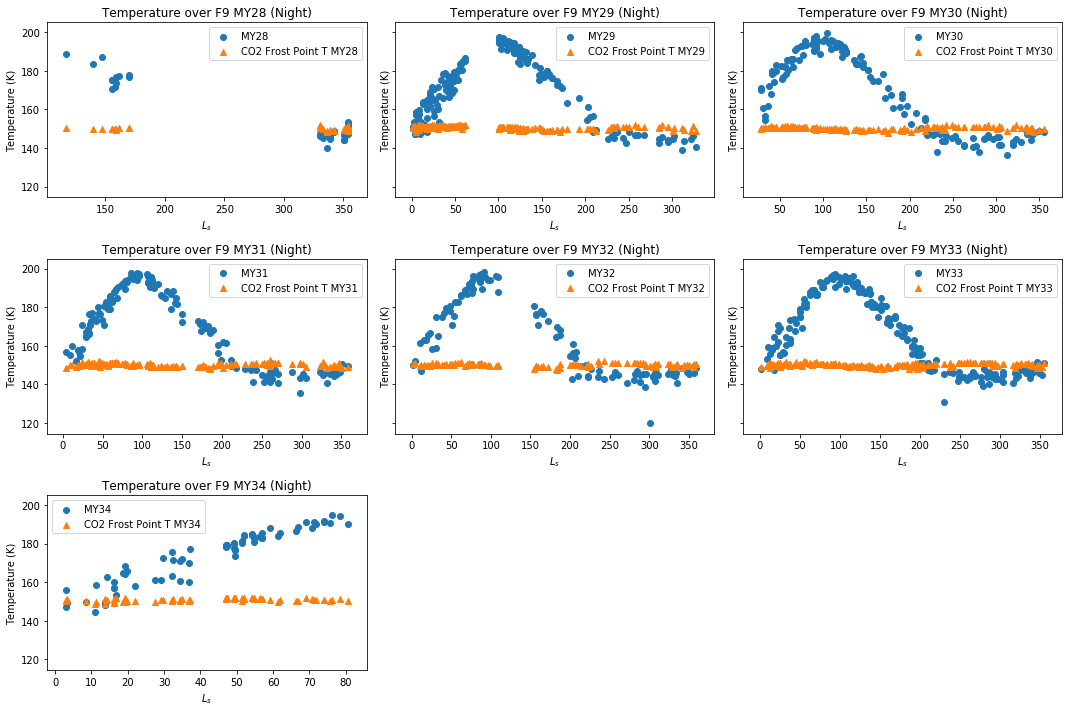

In [29]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(F9_SubframesNightMY28['L_s'],F9_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(F9_CO2night28['L_s'],F9_CO2night28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY28 (Night)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(F9_SubframesNightMY29['L_s'],F9_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(F9_CO2night29['L_s'],F9_CO2night29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY29 (Night)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(F9_SubframesNightMY30['L_s'],F9_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(F9_CO2night30['L_s'],F9_CO2night30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY30 (Night)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(F9_SubframesNightMY31['L_s'],F9_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(F9_CO2night31['L_s'],F9_CO2night31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY31 (Night)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(F9_SubframesNightMY32['L_s'],F9_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(F9_CO2night32['L_s'],F9_CO2night32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY32 (Night)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(F9_SubframesNightMY33['L_s'],F9_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(F9_CO2night33['L_s'],F9_CO2night33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY33 (Night)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(F9_SubframesNightMY34['L_s'],F9_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(F9_CO2night34['L_s'],F9_CO2night34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over F9 MY34 (Night)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

In [30]:
F9_SubframesDay = pd.concat([F9_SubframesDayMY28,
                              F9_SubframesDayMY29,
                              F9_SubframesDayMY30,
                              F9_SubframesDayMY31,
                              F9_SubframesDayMY32,
                              F9_SubframesDayMY33,
                              F9_SubframesDayMY34])

In [31]:
F9_SubframesNight = pd.concat([F9_SubframesNightMY28,
                              F9_SubframesNightMY29,
                              F9_SubframesNightMY30,
                              F9_SubframesNightMY31,
                              F9_SubframesNightMY32,
                              F9_SubframesNightMY33,
                              F9_SubframesNightMY34])

In [32]:
F9_SubframesDay = F9_SubframesDay.drop([' ','UTC'], axis=1)
F9_SubframesDay.to_csv('F9 MCS Data Day', sep=' ')

In [33]:
F9_SubframesNight = F9_SubframesNight.drop([' ','UTC'], axis=1)
F9_SubframesNight.to_csv('F9 MCS Data Night', sep=' ')

In [34]:
NML010 = square(41.74161, -135.6006, size=4, type = 'deg')

In [35]:
NML010_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))

NML010_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))

NML010_CO2day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))

NML010_CO2night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))
NML010_CO2night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML010[0],NML010[1]), RanLong=np.linspace(NML010[3], NML010[2]))

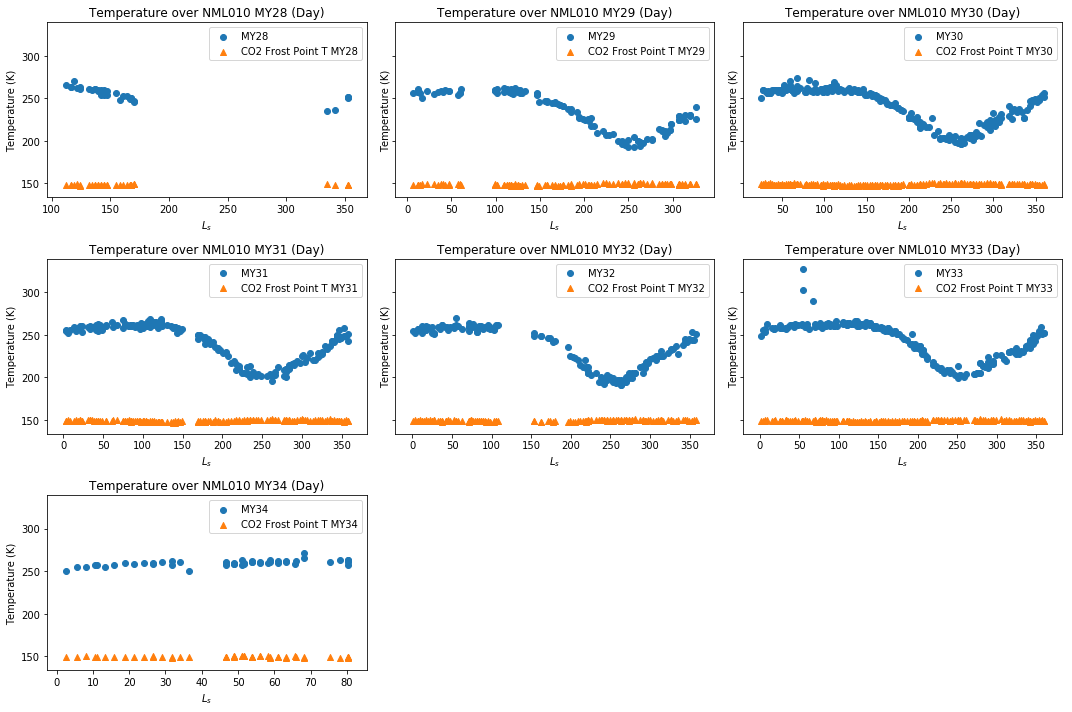

In [36]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(NML010_SubframesDayMY28['L_s'],NML010_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(NML010_CO2day28['L_s'],NML010_CO2day28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY28 (Day)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(NML010_SubframesDayMY29['L_s'],NML010_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(NML010_CO2day29['L_s'],NML010_CO2day29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY29 (Day)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(NML010_SubframesDayMY30['L_s'],NML010_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(NML010_CO2day30['L_s'],NML010_CO2day30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY30 (Day)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(NML010_SubframesDayMY31['L_s'],NML010_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(NML010_CO2day31['L_s'],NML010_CO2day31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY31 (Day)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(NML010_SubframesDayMY32['L_s'],NML010_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(NML010_CO2day32['L_s'],NML010_CO2day32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY32 (Day)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(NML010_SubframesDayMY33['L_s'],NML010_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(NML010_CO2day33['L_s'],NML010_CO2day33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY33 (Day)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(NML010_SubframesDayMY34['L_s'],NML010_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(NML010_CO2day34['L_s'],NML010_CO2day34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY34 (Day)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

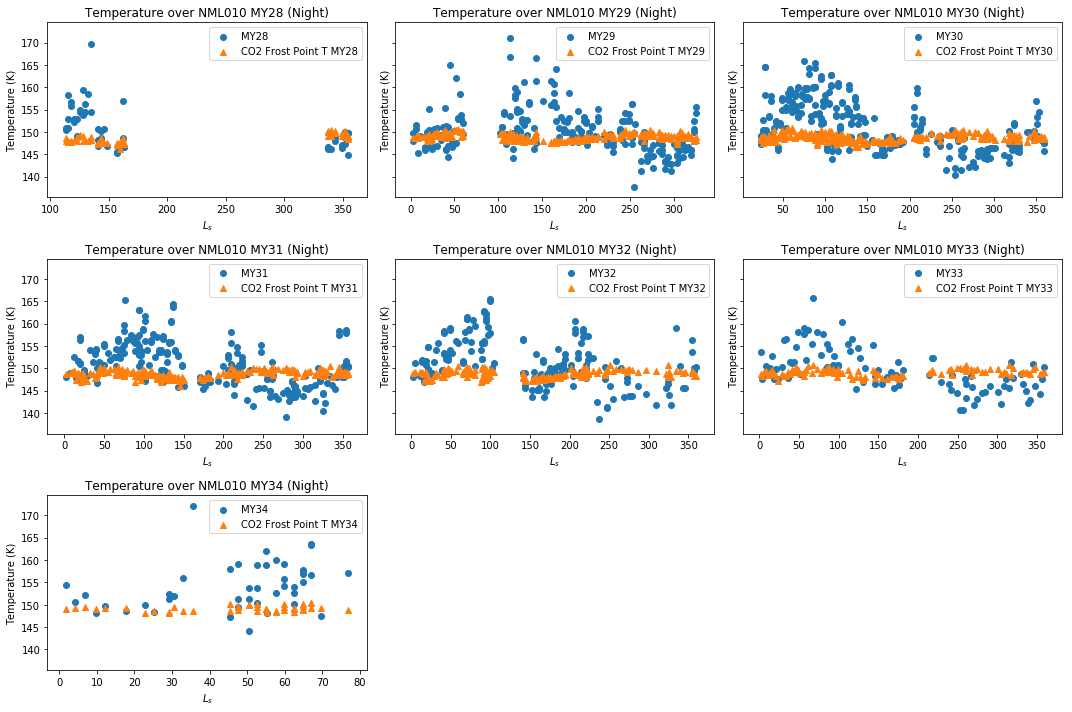

In [37]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(NML010_SubframesNightMY28['L_s'],NML010_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(NML010_CO2night28['L_s'],NML010_CO2night28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY28 (Night)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(NML010_SubframesNightMY29['L_s'],NML010_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(NML010_CO2night29['L_s'],NML010_CO2night29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY29 (Night)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(NML010_SubframesNightMY30['L_s'],NML010_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(NML010_CO2night30['L_s'],NML010_CO2night30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY30 (Night)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(NML010_SubframesNightMY31['L_s'],NML010_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(NML010_CO2night31['L_s'],NML010_CO2night31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY31 (Night)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(NML010_SubframesNightMY32['L_s'],NML010_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(NML010_CO2night32['L_s'],NML010_CO2night32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY32 (Night)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(NML010_SubframesNightMY33['L_s'],NML010_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(NML010_CO2night33['L_s'],NML010_CO2night33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY33 (Night)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(NML010_SubframesNightMY34['L_s'],NML010_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(NML010_CO2night34['L_s'],NML010_CO2night34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML010 MY34 (Night)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

In [38]:
NML010_SubframesDay = pd.concat([NML010_SubframesDayMY28,
                              NML010_SubframesDayMY29,
                              NML010_SubframesDayMY30,
                              NML010_SubframesDayMY31,
                              NML010_SubframesDayMY32,
                              NML010_SubframesDayMY33,
                              NML010_SubframesDayMY34])

In [39]:
NML010_SubframesNight = pd.concat([NML010_SubframesNightMY28,
                              NML010_SubframesNightMY29,
                              NML010_SubframesNightMY30,
                              NML010_SubframesNightMY31,
                              NML010_SubframesNightMY32,
                              NML010_SubframesNightMY33,
                              NML010_SubframesNightMY34])

In [40]:
NML010_SubframesDay = NML010_SubframesDay.drop([' ','UTC'], axis=1)
NML010_SubframesDay.to_csv('NML010 MCS Data Day', sep=' ')

In [41]:
NML010_SubframesNight = NML010_SubframesNight.drop([' ','UTC'], axis=1)
NML010_SubframesNight.to_csv('NML010 MCS Data Night', sep=' ')

In [42]:
NML043 = square(63.75526, 112.1203, size=4, type = 'deg')

In [43]:
NML043_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))

NML043_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))

NML043_CO2day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))

NML043_CO2night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))
NML043_CO2night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML043[0],NML043[1]), RanLong=np.linspace(NML043[3], NML043[2]))

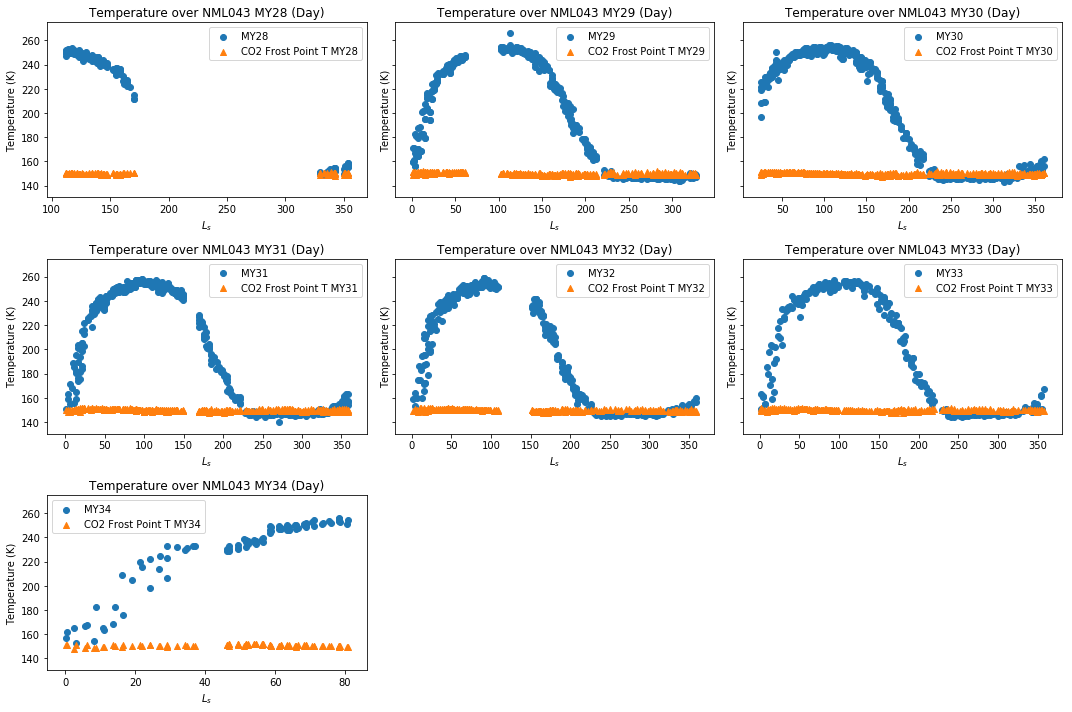

In [44]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(NML043_SubframesDayMY28['L_s'],NML043_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(NML043_CO2day28['L_s'],NML043_CO2day28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY28 (Day)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(NML043_SubframesDayMY29['L_s'],NML043_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(NML043_CO2day29['L_s'],NML043_CO2day29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY29 (Day)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(NML043_SubframesDayMY30['L_s'],NML043_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(NML043_CO2day30['L_s'],NML043_CO2day30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY30 (Day)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(NML043_SubframesDayMY31['L_s'],NML043_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(NML043_CO2day31['L_s'],NML043_CO2day31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY31 (Day)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(NML043_SubframesDayMY32['L_s'],NML043_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(NML043_CO2day32['L_s'],NML043_CO2day32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY32 (Day)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(NML043_SubframesDayMY33['L_s'],NML043_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(NML043_CO2day33['L_s'],NML043_CO2day33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY33 (Day)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(NML043_SubframesDayMY34['L_s'],NML043_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(NML043_CO2day34['L_s'],NML043_CO2day34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY34 (Day)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

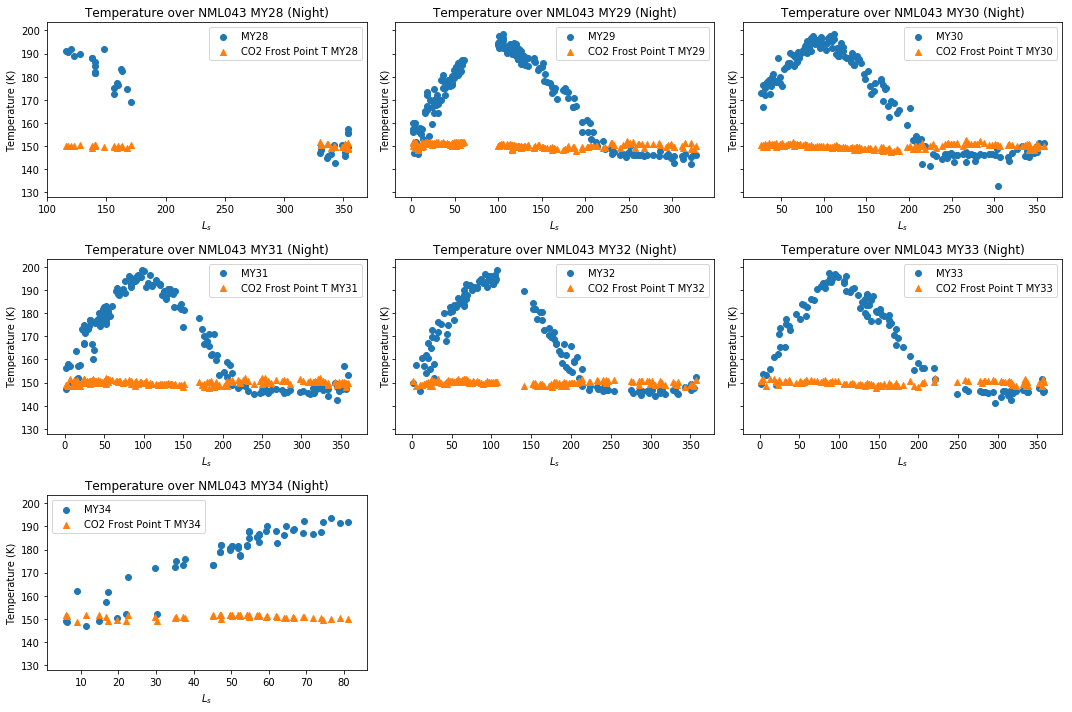

In [45]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(NML043_SubframesNightMY28['L_s'],NML043_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(NML043_CO2night28['L_s'],NML043_CO2night28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY28 (Night)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(NML043_SubframesNightMY29['L_s'],NML043_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(NML043_CO2night29['L_s'],NML043_CO2night29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY29 (Night)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(NML043_SubframesNightMY30['L_s'],NML043_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(NML043_CO2night30['L_s'],NML043_CO2night30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY30 (Night)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(NML043_SubframesNightMY31['L_s'],NML043_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(NML043_CO2night31['L_s'],NML043_CO2night31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY31 (Night)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(NML043_SubframesNightMY32['L_s'],NML043_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(NML043_CO2night32['L_s'],NML043_CO2night32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY32 (Night)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(NML043_SubframesNightMY33['L_s'],NML043_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(NML043_CO2night33['L_s'],NML043_CO2night33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY33 (Night)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(NML043_SubframesNightMY34['L_s'],NML043_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(NML043_CO2night34['L_s'],NML043_CO2night34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML043 MY34 (Night)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

In [46]:
NML043_SubframesDay = pd.concat([NML043_SubframesDayMY28,
                              NML043_SubframesDayMY29,
                              NML043_SubframesDayMY30,
                              NML043_SubframesDayMY31,
                              NML043_SubframesDayMY32,
                              NML043_SubframesDayMY33,
                              NML043_SubframesDayMY34])

In [47]:
NML043_SubframesNight = pd.concat([NML043_SubframesNightMY28,
                              NML043_SubframesNightMY29,
                              NML043_SubframesNightMY30,
                              NML043_SubframesNightMY31,
                              NML043_SubframesNightMY32,
                              NML043_SubframesNightMY33,
                              NML043_SubframesNightMY34])

In [48]:
NML043_SubframesDay = NML043_SubframesDay.drop([' ','UTC'], axis=1)
NML043_SubframesDay.to_csv('NML043 MCS Data Day', sep=' ')

In [49]:
NML043_SubframesNight = NML043_SubframesNight.drop([' ','UTC'], axis=1)
NML043_SubframesNight.to_csv('NML043 MCS Data Night', sep=' ')

In [50]:
NML047 = square(54.46798, 33.5177, size=4, type = 'deg')

In [51]:
NML047_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))

NML047_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))

NML047_CO2day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))

NML047_CO2night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))
NML047_CO2night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML047[0],NML047[1]), RanLong=np.linspace(NML047[3], NML047[2]))

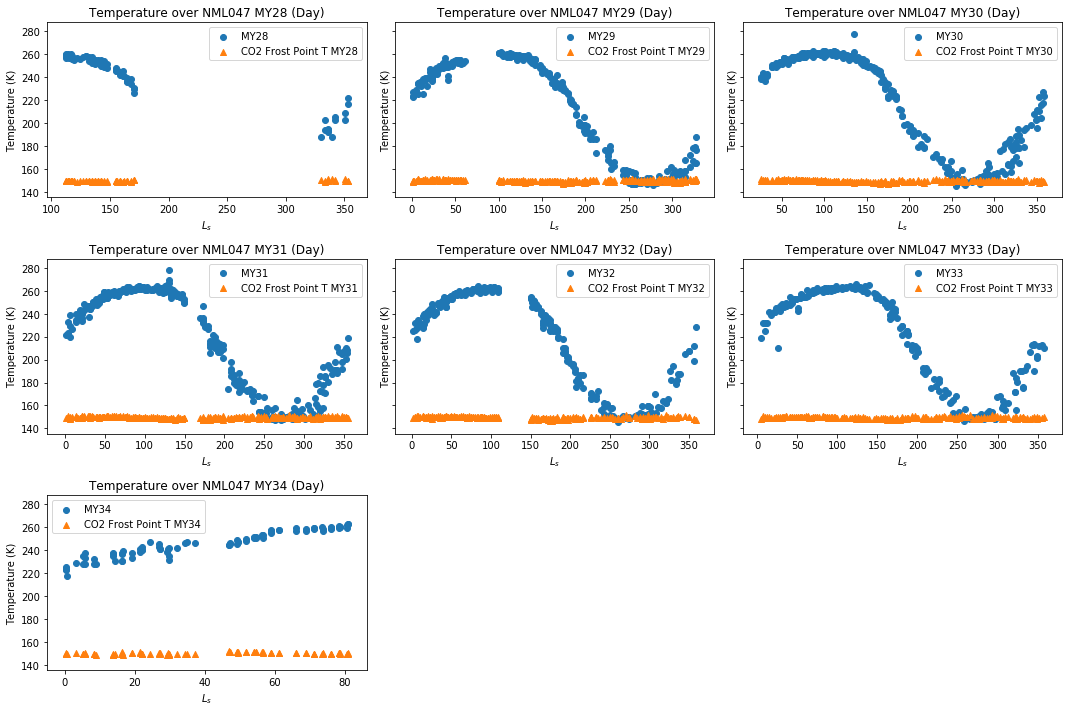

In [52]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(NML047_SubframesDayMY28['L_s'],NML047_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(NML047_CO2day28['L_s'],NML047_CO2day28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY28 (Day)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(NML047_SubframesDayMY29['L_s'],NML047_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(NML047_CO2day29['L_s'],NML047_CO2day29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY29 (Day)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(NML047_SubframesDayMY30['L_s'],NML047_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(NML047_CO2day30['L_s'],NML047_CO2day30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY30 (Day)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(NML047_SubframesDayMY31['L_s'],NML047_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(NML047_CO2day31['L_s'],NML047_CO2day31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY31 (Day)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(NML047_SubframesDayMY32['L_s'],NML047_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(NML047_CO2day32['L_s'],NML047_CO2day32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY32 (Day)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(NML047_SubframesDayMY33['L_s'],NML047_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(NML047_CO2day33['L_s'],NML047_CO2day33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY33 (Day)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(NML047_SubframesDayMY34['L_s'],NML047_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(NML047_CO2day34['L_s'],NML047_CO2day34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY34 (Day)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

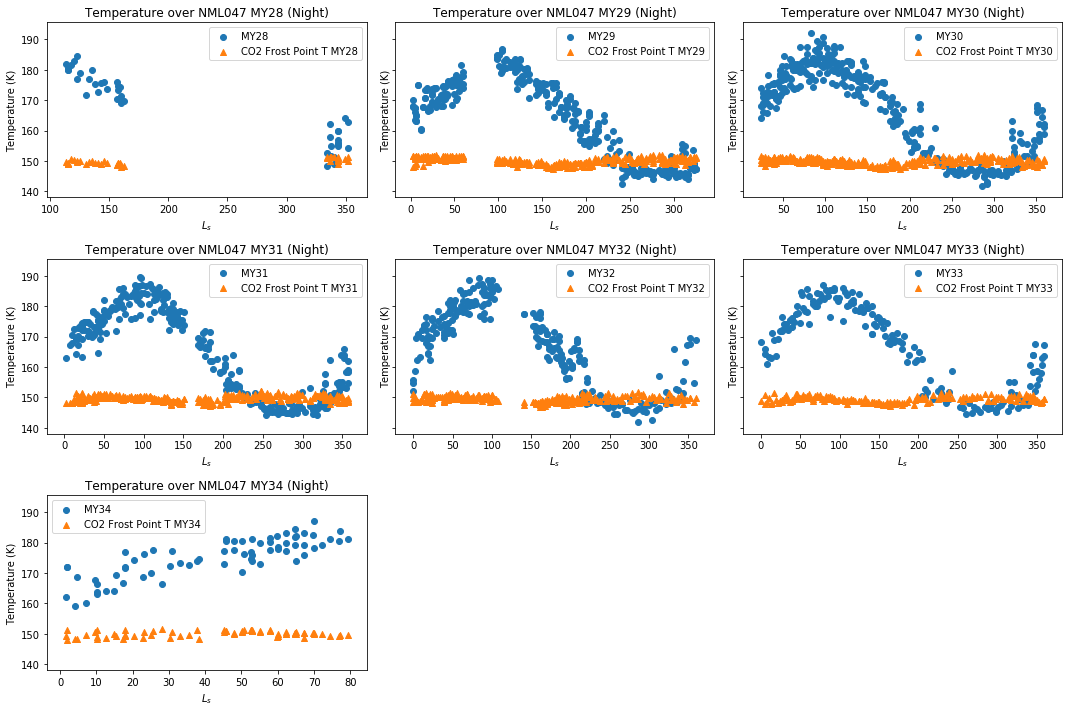

In [53]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(NML047_SubframesNightMY28['L_s'],NML047_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(NML047_CO2night28['L_s'],NML047_CO2night28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY28 (Night)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(NML047_SubframesNightMY29['L_s'],NML047_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(NML047_CO2night29['L_s'],NML047_CO2night29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY29 (Night)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(NML047_SubframesNightMY30['L_s'],NML047_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(NML047_CO2night30['L_s'],NML047_CO2night30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY30 (Night)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(NML047_SubframesNightMY31['L_s'],NML047_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(NML047_CO2night31['L_s'],NML047_CO2night31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY31 (Night)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(NML047_SubframesNightMY32['L_s'],NML047_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(NML047_CO2night32['L_s'],NML047_CO2night32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY32 (Night)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(NML047_SubframesNightMY33['L_s'],NML047_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(NML047_CO2night33['L_s'],NML047_CO2night33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY33 (Night)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(NML047_SubframesNightMY34['L_s'],NML047_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(NML047_CO2night34['L_s'],NML047_CO2night34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY34 (Night)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

In [54]:
NML047_SubframesDay = pd.concat([NML047_SubframesDayMY28,
                              NML047_SubframesDayMY29,
                              NML047_SubframesDayMY30,
                              NML047_SubframesDayMY31,
                              NML047_SubframesDayMY32,
                              NML047_SubframesDayMY33,
                              NML047_SubframesDayMY34])

In [55]:
NML047_SubframesNight = pd.concat([NML047_SubframesNightMY28,
                              NML047_SubframesNightMY29,
                              NML047_SubframesNightMY30,
                              NML047_SubframesNightMY31,
                              NML047_SubframesNightMY32,
                              NML047_SubframesNightMY33,
                              NML047_SubframesNightMY34])

In [56]:
NML047_SubframesDay = NML047_SubframesDay.drop([' ','UTC'], axis=1)
NML047_SubframesDay.to_csv('NML047 MCS Data Day', sep=' ')

In [57]:
NML047_SubframesNight = NML047_SubframesNight.drop([' ','UTC'], axis=1)
NML047_SubframesNight.to_csv('NML047 MCS Data Night', sep=' ')

In [58]:
NML086 = square(58.25693, -90.35472, size=4, type = 'deg')

In [59]:
NML086_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))

NML086_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))

NML086_CO2day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))

NML086_CO2night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))
NML086_CO2night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(NML086[0],NML086[1]), RanLong=np.linspace(NML086[3], NML086[2]))

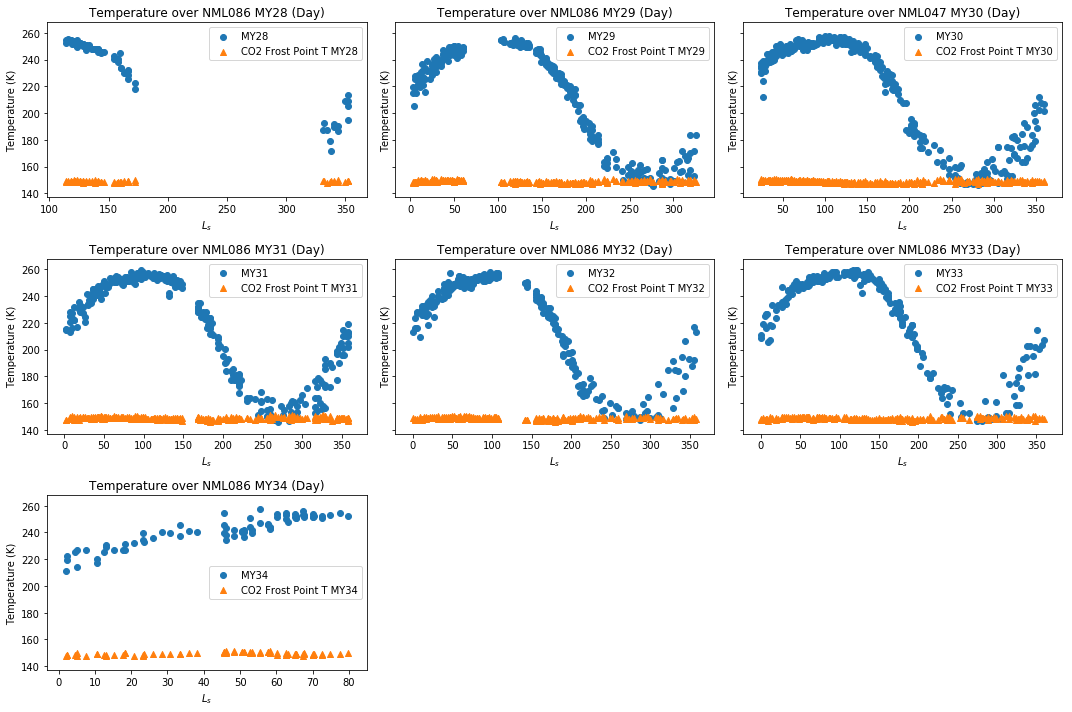

In [60]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(NML086_SubframesDayMY28['L_s'],NML086_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(NML086_CO2day28['L_s'],NML086_CO2day28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY28 (Day)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(NML086_SubframesDayMY29['L_s'],NML086_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(NML086_CO2day29['L_s'],NML086_CO2day29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY29 (Day)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(NML086_SubframesDayMY30['L_s'],NML086_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(NML086_CO2day30['L_s'],NML086_CO2day30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML047 MY30 (Day)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(NML086_SubframesDayMY31['L_s'],NML086_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(NML086_CO2day31['L_s'],NML086_CO2day31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY31 (Day)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(NML086_SubframesDayMY32['L_s'],NML086_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(NML086_CO2day32['L_s'],NML086_CO2day32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY32 (Day)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(NML086_SubframesDayMY33['L_s'],NML086_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(NML086_CO2day33['L_s'],NML086_CO2day33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY33 (Day)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(NML086_SubframesDayMY34['L_s'],NML086_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(NML086_CO2day34['L_s'],NML086_CO2day34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY34 (Day)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

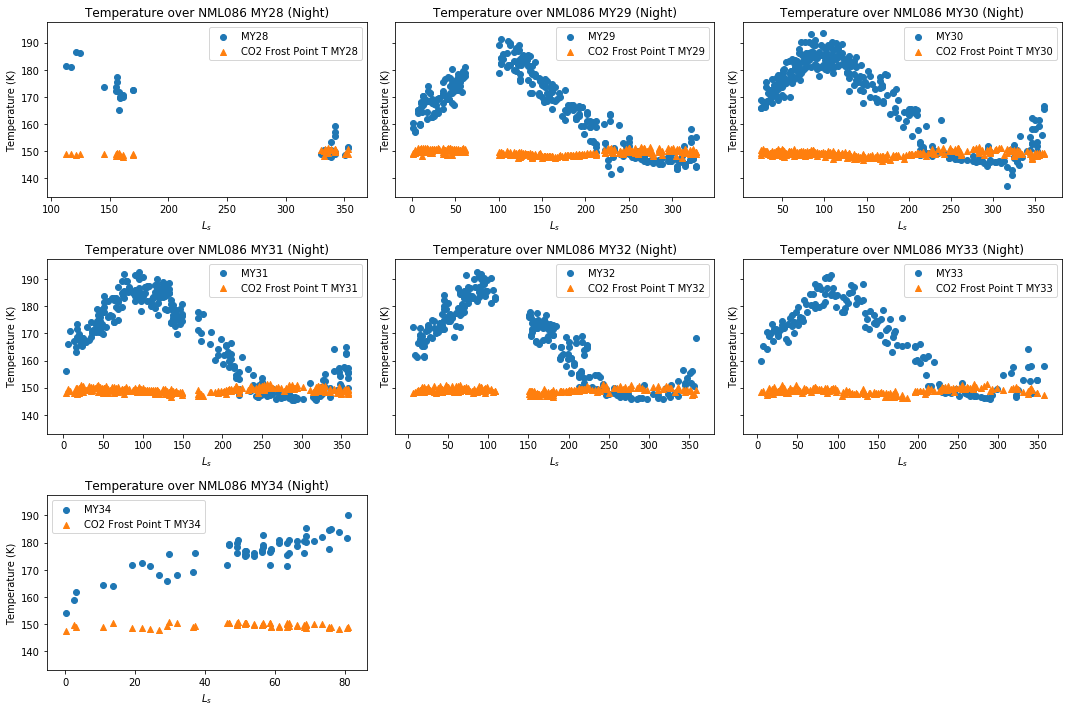

In [61]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(NML086_SubframesNightMY28['L_s'],NML086_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(NML086_CO2night28['L_s'],NML086_CO2night28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY28 (Night)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(NML086_SubframesNightMY29['L_s'],NML086_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(NML086_CO2night29['L_s'],NML086_CO2night29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY29 (Night)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(NML086_SubframesNightMY30['L_s'],NML086_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(NML086_CO2night30['L_s'],NML086_CO2night30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY30 (Night)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(NML086_SubframesNightMY31['L_s'],NML086_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(NML086_CO2night31['L_s'],NML086_CO2night31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY31 (Night)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(NML086_SubframesNightMY32['L_s'],NML086_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(NML086_CO2night32['L_s'],NML086_CO2night32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY32 (Night)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(NML086_SubframesNightMY33['L_s'],NML086_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(NML086_CO2night33['L_s'],NML086_CO2night33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY33 (Night)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(NML086_SubframesNightMY34['L_s'],NML086_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(NML086_CO2night34['L_s'],NML086_CO2night34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over NML086 MY34 (Night)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

In [62]:
NML086_SubframesDay = pd.concat([NML086_SubframesDayMY28,
                              NML086_SubframesDayMY29,
                              NML086_SubframesDayMY30,
                              NML086_SubframesDayMY31,
                              NML086_SubframesDayMY32,
                              NML086_SubframesDayMY33,
                              NML086_SubframesDayMY34])

In [63]:
NML086_SubframesNight = pd.concat([NML086_SubframesNightMY28,
                              NML086_SubframesNightMY29,
                              NML086_SubframesNightMY30,
                              NML086_SubframesNightMY31,
                              NML086_SubframesNightMY32,
                              NML086_SubframesNightMY33,
                              NML086_SubframesNightMY34])

In [64]:
NML086_SubframesDay = NML086_SubframesDay.drop([' ','UTC'], axis=1)
NML086_SubframesDay.to_csv('NML086 MCS Data Day', sep=' ')

In [65]:
NML086_SubframesNight = NML086_SubframesNight.drop([' ','UTC'], axis=1)
NML086_SubframesNight.to_csv('NML086 MCS Data Night', sep=' ')

In [82]:
Buzzel = square(84.0, 53.2, size=1, type = 'deg')

In [83]:
Buzzel_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))

Buzzel_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))

Buzzel_CO2Day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))

Buzzel_CO2Night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))
Buzzel_CO2Night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Buzzel[0],Buzzel[1]), RanLong=np.linspace(Buzzel[3],Buzzel[2]))

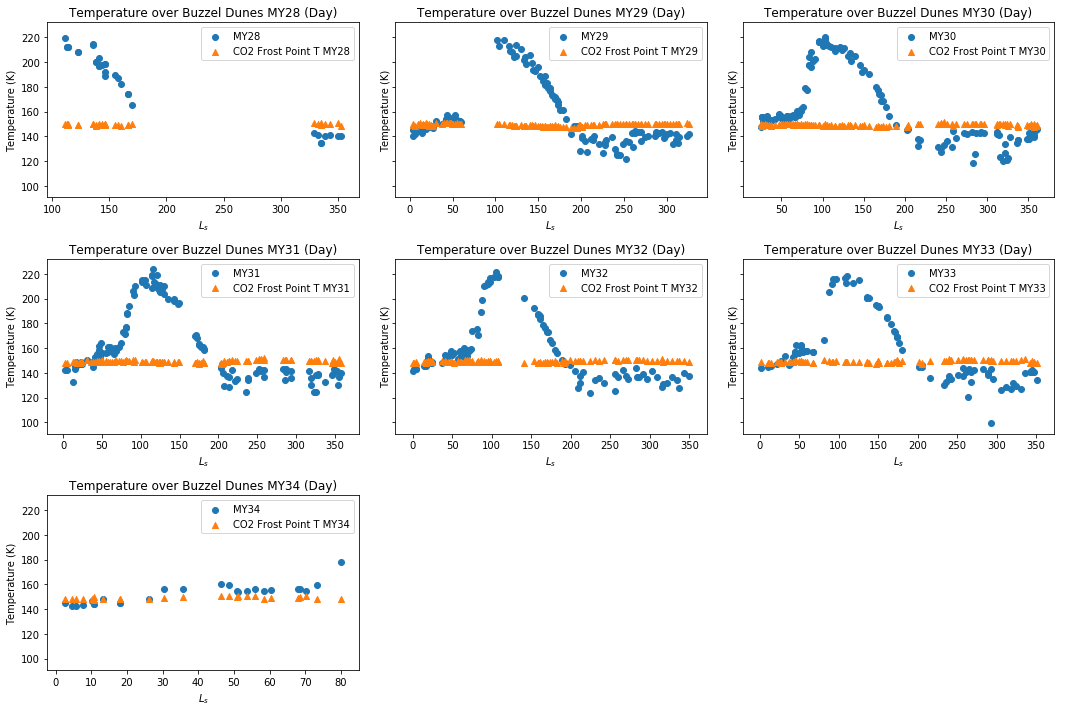

In [84]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Buzzel_SubframesDayMY28['L_s'], Buzzel_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(Buzzel_CO2Day28['L_s'],Buzzel_CO2Day28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY28 (Day)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Buzzel_SubframesDayMY29['L_s'], Buzzel_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(Buzzel_CO2Day29['L_s'],Buzzel_CO2Day29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY29 (Day)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Buzzel_SubframesDayMY30['L_s'], Buzzel_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(Buzzel_CO2Day30['L_s'],Buzzel_CO2Day30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY30 (Day)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Buzzel_SubframesDayMY31['L_s'], Buzzel_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(Buzzel_CO2Day31['L_s'],Buzzel_CO2Day31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY31 (Day)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Buzzel_SubframesDayMY32['L_s'], Buzzel_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(Buzzel_CO2Day32['L_s'],Buzzel_CO2Day32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY32 (Day)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Buzzel_SubframesDayMY33['L_s'], Buzzel_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(Buzzel_CO2Day33['L_s'],Buzzel_CO2Day33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY33 (Day)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Buzzel_SubframesDayMY34['L_s'], Buzzel_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(Buzzel_CO2Day34['L_s'],Buzzel_CO2Day34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY34 (Day)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

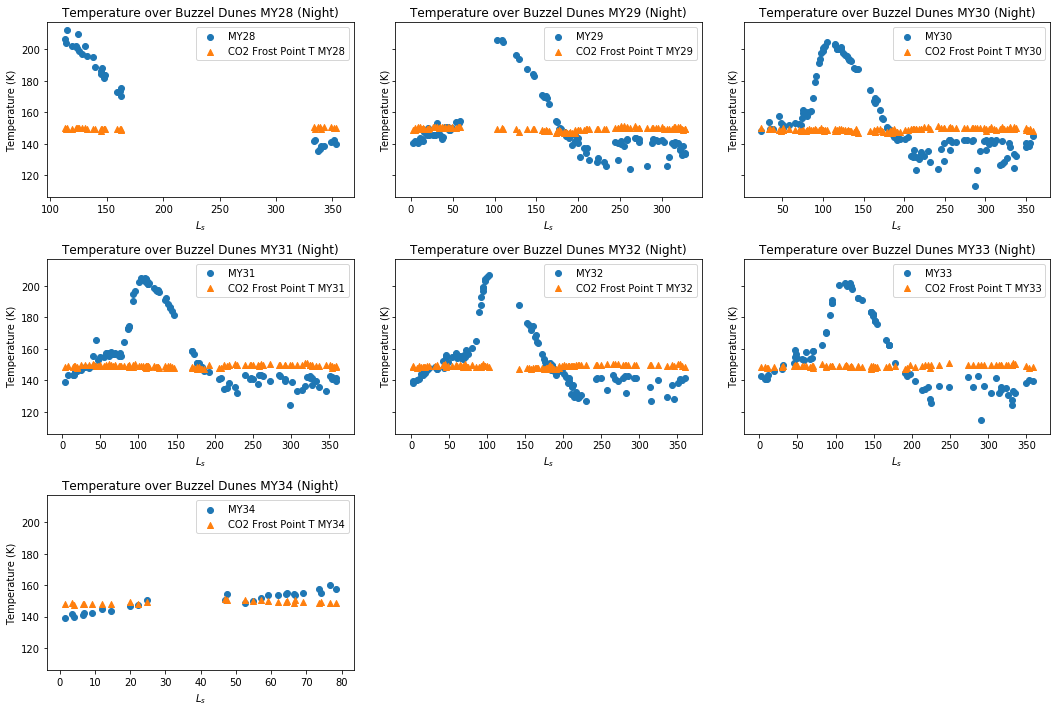

In [85]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Buzzel_SubframesNightMY28['L_s'], Buzzel_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(Buzzel_CO2Night28['L_s'],Buzzel_CO2Night28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY28 (Night)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Buzzel_SubframesNightMY29['L_s'], Buzzel_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(Buzzel_CO2Night29['L_s'],Buzzel_CO2Night29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY29 (Night)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Buzzel_SubframesNightMY30['L_s'], Buzzel_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(Buzzel_CO2Night30['L_s'],Buzzel_CO2Night30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY30 (Night)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Buzzel_SubframesNightMY31['L_s'], Buzzel_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(Buzzel_CO2Night31['L_s'],Buzzel_CO2Night31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY31 (Night)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Buzzel_SubframesNightMY32['L_s'], Buzzel_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(Buzzel_CO2Night32['L_s'],Buzzel_CO2Night32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY32 (Night)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Buzzel_SubframesNightMY33['L_s'], Buzzel_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(Buzzel_CO2Night33['L_s'],Buzzel_CO2Night33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY33 (Night)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Buzzel_SubframesNightMY34['L_s'], Buzzel_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(Buzzel_CO2Night34['L_s'],Buzzel_CO2Night34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes MY34 (Night)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

In [87]:
Kolhar = square(84.7, -179.3, size=1, type = 'deg')

In [88]:
Kolhar_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))

Kolhar_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))

Kolhar_CO2Day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))

Kolhar_CO2Night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))
Kolhar_CO2Night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Kolhar[0],Kolhar[1]), RanLong=np.linspace(Kolhar[3],Kolhar[2]))

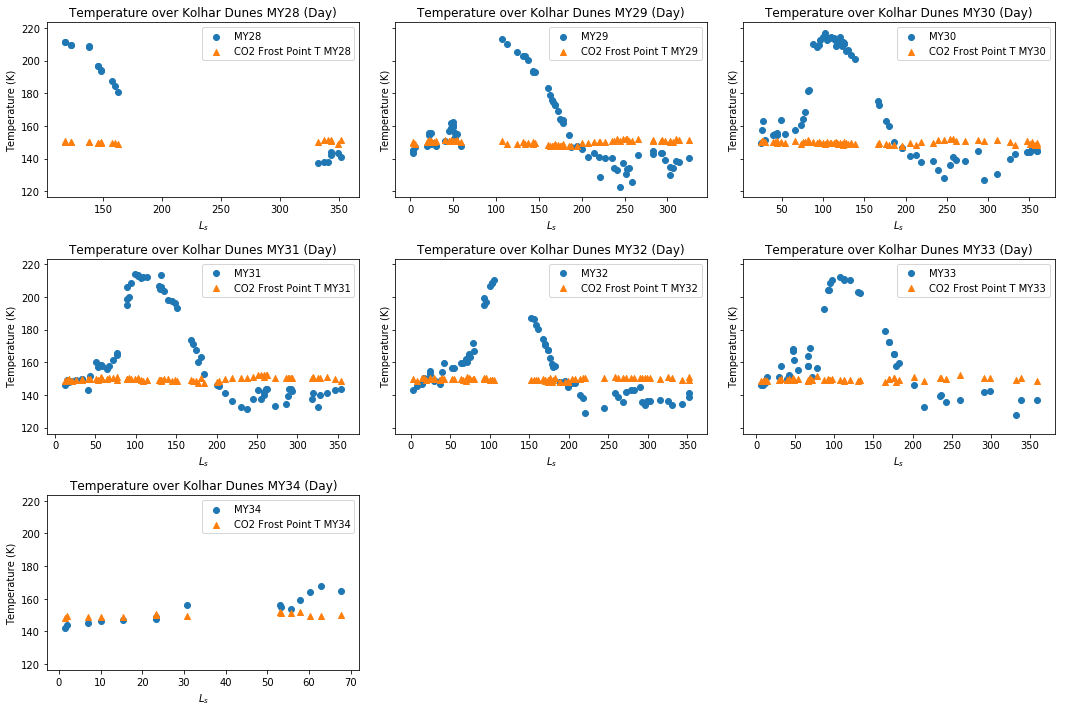

In [89]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Kolhar_SubframesDayMY28['L_s'], Kolhar_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(Kolhar_CO2Day28['L_s'],Kolhar_CO2Day28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY28 (Day)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Kolhar_SubframesDayMY29['L_s'], Kolhar_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(Kolhar_CO2Day29['L_s'],Kolhar_CO2Day29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY29 (Day)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Kolhar_SubframesDayMY30['L_s'], Kolhar_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(Kolhar_CO2Day30['L_s'],Kolhar_CO2Day30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY30 (Day)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Kolhar_SubframesDayMY31['L_s'], Kolhar_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(Kolhar_CO2Day31['L_s'],Kolhar_CO2Day31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY31 (Day)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Kolhar_SubframesDayMY32['L_s'], Kolhar_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(Kolhar_CO2Day32['L_s'],Kolhar_CO2Day32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY32 (Day)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Kolhar_SubframesDayMY33['L_s'], Kolhar_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(Kolhar_CO2Day33['L_s'],Kolhar_CO2Day33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY33 (Day)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Kolhar_SubframesDayMY34['L_s'], Kolhar_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(Kolhar_CO2Day34['L_s'],Kolhar_CO2Day34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY34 (Day)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

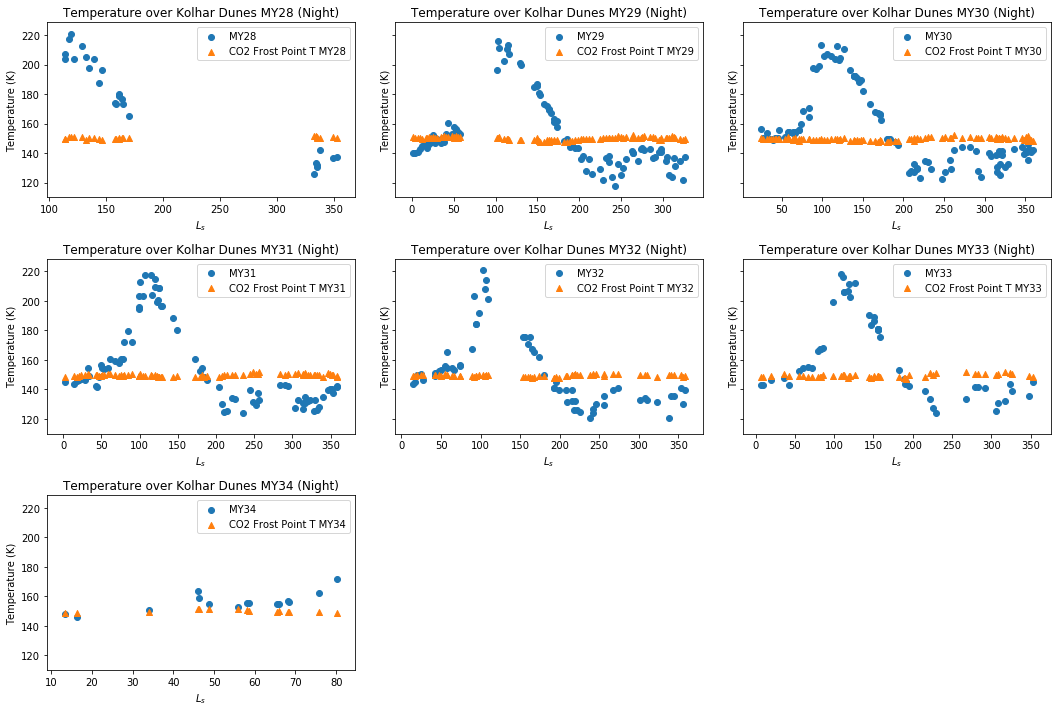

In [90]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Kolhar_SubframesNightMY28['L_s'], Kolhar_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(Kolhar_CO2Night28['L_s'],Kolhar_CO2Night28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY28 (Night)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Kolhar_SubframesNightMY29['L_s'], Kolhar_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(Kolhar_CO2Night29['L_s'],Kolhar_CO2Night29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY29 (Night)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Kolhar_SubframesNightMY30['L_s'], Kolhar_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(Kolhar_CO2Night30['L_s'],Kolhar_CO2Night30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY30 (Night)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Kolhar_SubframesNightMY31['L_s'], Kolhar_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(Kolhar_CO2Night31['L_s'],Kolhar_CO2Night31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY31 (Night)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Kolhar_SubframesNightMY32['L_s'], Kolhar_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(Kolhar_CO2Night32['L_s'],Kolhar_CO2Night32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY32 (Night)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Kolhar_SubframesNightMY33['L_s'], Kolhar_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(Kolhar_CO2Night33['L_s'],Kolhar_CO2Night33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY33 (Night)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Kolhar_SubframesNightMY34['L_s'], Kolhar_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(Kolhar_CO2Night34['L_s'],Kolhar_CO2Night34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes MY34 (Night)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

In [91]:
Tleilax = square(83.5, -61.4, size=1, type = 'deg')

In [92]:
Tleilax_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))

Tleilax_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))

Tleilax_CO2Day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))

Tleilax_CO2Night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))
Tleilax_CO2Night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Tleilax[0],Tleilax[1]), RanLong=np.linspace(Tleilax[3],Tleilax[2]))

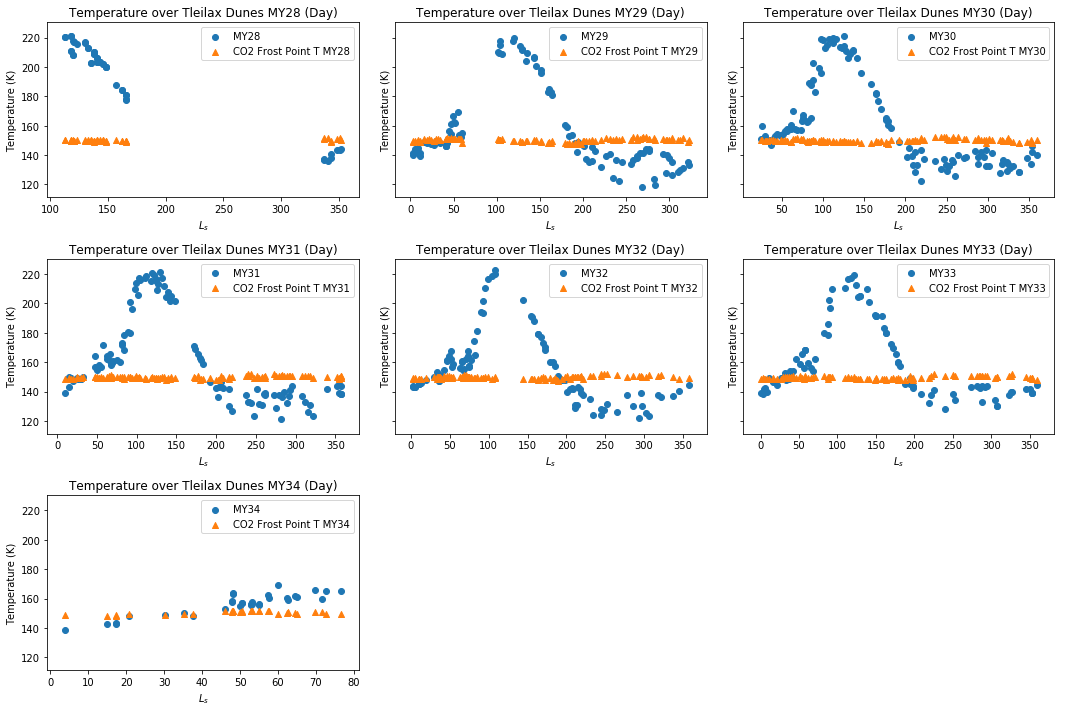

In [93]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Tleilax_SubframesDayMY28['L_s'], Tleilax_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(Tleilax_CO2Day28['L_s'],Tleilax_CO2Day28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY28 (Day)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Tleilax_SubframesDayMY29['L_s'], Tleilax_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(Tleilax_CO2Day29['L_s'],Tleilax_CO2Day29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY29 (Day)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Tleilax_SubframesDayMY30['L_s'], Tleilax_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(Tleilax_CO2Day30['L_s'],Tleilax_CO2Day30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY30 (Day)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Tleilax_SubframesDayMY31['L_s'], Tleilax_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(Tleilax_CO2Day31['L_s'],Tleilax_CO2Day31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY31 (Day)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Tleilax_SubframesDayMY32['L_s'], Tleilax_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(Tleilax_CO2Day32['L_s'],Tleilax_CO2Day32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY32 (Day)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Tleilax_SubframesDayMY33['L_s'], Tleilax_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(Tleilax_CO2Day33['L_s'],Tleilax_CO2Day33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY33 (Day)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Tleilax_SubframesDayMY34['L_s'], Tleilax_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(Tleilax_CO2Day34['L_s'],Tleilax_CO2Day34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY34 (Day)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

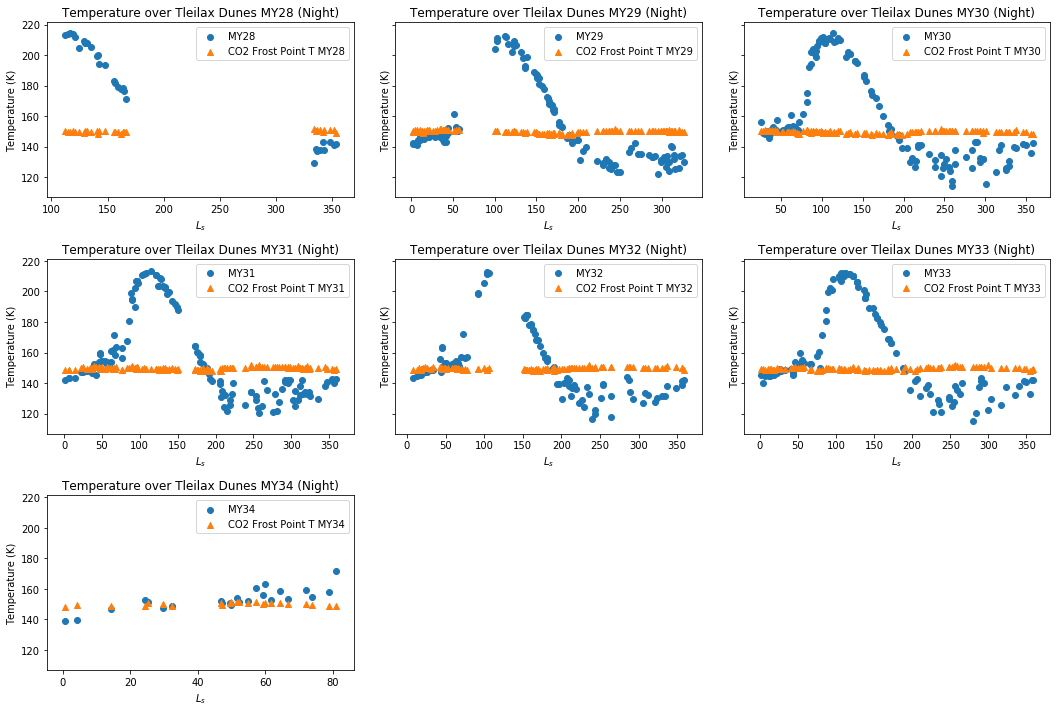

In [94]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Tleilax_SubframesNightMY28['L_s'], Tleilax_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(Tleilax_CO2Night28['L_s'],Tleilax_CO2Night28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY28 (Night)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Tleilax_SubframesNightMY29['L_s'], Tleilax_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(Tleilax_CO2Night29['L_s'],Tleilax_CO2Night29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY29 (Night)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Tleilax_SubframesNightMY30['L_s'], Tleilax_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(Tleilax_CO2Night30['L_s'],Tleilax_CO2Night30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY30 (Night)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Tleilax_SubframesNightMY31['L_s'], Tleilax_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(Tleilax_CO2Night31['L_s'],Tleilax_CO2Night31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY31 (Night)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Tleilax_SubframesNightMY32['L_s'], Tleilax_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(Tleilax_CO2Night32['L_s'],Tleilax_CO2Night32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY32 (Night)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Tleilax_SubframesNightMY33['L_s'], Tleilax_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(Tleilax_CO2Night33['L_s'],Tleilax_CO2Night33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY33 (Night)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Tleilax_SubframesNightMY34['L_s'], Tleilax_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(Tleilax_CO2Night34['L_s'],Tleilax_CO2Night34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes MY34 (Night)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

In [98]:
Palma = square(76.2, -84.6, size=1, type = 'deg')

In [99]:
Palma_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))

Palma_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))

Palma_CO2Day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))

Palma_CO2Night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))
Palma_CO2Night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(Palma[0],Palma[1]), RanLong=np.linspace(Palma[3],Palma[2]))

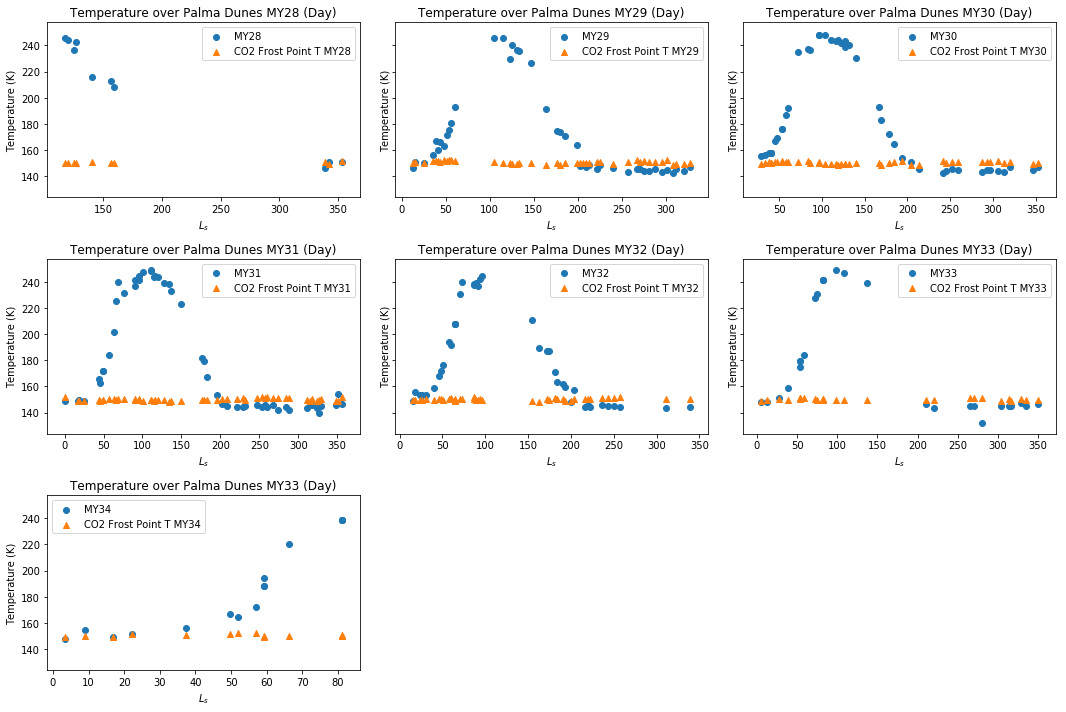

In [100]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Palma_SubframesDayMY28['L_s'], Palma_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(Palma_CO2Day28['L_s'],Palma_CO2Day28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY28 (Day)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Palma_SubframesDayMY29['L_s'], Palma_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(Palma_CO2Day29['L_s'],Palma_CO2Day29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY29 (Day)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Palma_SubframesDayMY30['L_s'], Palma_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(Palma_CO2Day30['L_s'],Palma_CO2Day30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY30 (Day)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Palma_SubframesDayMY31['L_s'], Palma_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(Palma_CO2Day31['L_s'],Palma_CO2Day31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY31 (Day)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Palma_SubframesDayMY32['L_s'], Palma_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(Palma_CO2Day32['L_s'],Palma_CO2Day32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY32 (Day)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Palma_SubframesDayMY33['L_s'], Palma_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(Palma_CO2Day33['L_s'],Palma_CO2Day33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY33 (Day)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Palma_SubframesDayMY34['L_s'], Palma_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(Palma_CO2Day34['L_s'],Palma_CO2Day34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY33 (Day)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()

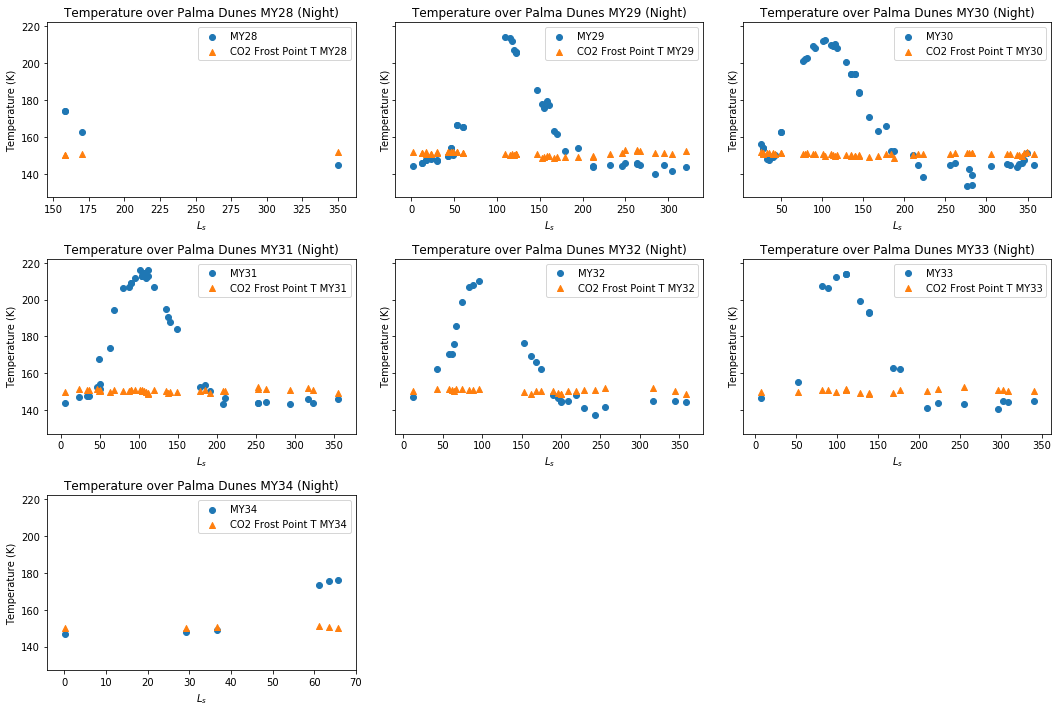

In [101]:
fig, axes = plt.subplots(3,3, sharex = False, sharey = True ,figsize= (15,10))
plt.sca(axes[0,0])
plt.scatter(Palma_SubframesNightMY28['L_s'], Palma_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(Palma_CO2Night28['L_s'],Palma_CO2Night28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY28 (Night)')
plt.legend()
plt.sca(axes[0,1])
plt.scatter(Palma_SubframesNightMY29['L_s'], Palma_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(Palma_CO2Night29['L_s'],Palma_CO2Night29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY29 (Night)')
plt.legend()
plt.sca(axes[0,2])
plt.scatter(Palma_SubframesNightMY30['L_s'], Palma_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(Palma_CO2Night30['L_s'],Palma_CO2Night30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY30 (Night)')
plt.legend()
plt.sca(axes[1,0])
plt.scatter(Palma_SubframesNightMY31['L_s'], Palma_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(Palma_CO2Night31['L_s'],Palma_CO2Night31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY31 (Night)')
plt.legend()
plt.sca(axes[1,1])
plt.scatter(Palma_SubframesNightMY32['L_s'], Palma_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(Palma_CO2Night32['L_s'],Palma_CO2Night32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY32 (Night)')
plt.legend()
plt.sca(axes[1,2])
plt.scatter(Palma_SubframesNightMY33['L_s'], Palma_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(Palma_CO2Night33['L_s'],Palma_CO2Night33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY33 (Night)')
plt.legend()
plt.sca(axes[2,0])
plt.scatter(Palma_SubframesNightMY34['L_s'], Palma_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(Palma_CO2Night34['L_s'],Palma_CO2Night34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes MY34 (Night)')
plt.legend()
axes[2,1].remove()
axes[2,2].remove()
plt.tight_layout()
plt.show()